In [32]:
#!use/bin/Nenv python
# coding: utf-8

import pandas as pd
import numpy as np
import scipy.special as comb
import math
from operator import mul
import neal
import dimod
import random
import matplotlib.pyplot as plt
import timeit
import time
from itertools import combinations


def calc_marginals(df):
	return np.array(
        [sum(df['Y']),
         np.dot(df['Y'], df['SEX']),
         np.dot(df['Y'], df['AOP'])
		])


def make_Hamiltonian(df):
    t_list = calc_marginals(df)
    
    N=len(df)
    dup_list = [(i, i) for i in range(N)]
    comb_list = [(i, j) for i in range(N) for j in range(i+1, N)]
    
    lin_Y = [1-2*t_list[0] for (i, _) in dup_list] #同じy同士
    quad_Y = [2 for (i, j) in comb_list] #異なるy同士
    num_Y = t_list[0]**2 #数字の二乗
    
    SEX = df['SEX'].iloc
    lin_SEX  = [(SEX[i] - 2 * t_list[1]) * SEX[i] for (i, _) in dup_list]
    quad_SEX  = [2*SEX[i] * SEX[j] for (i, j) in comb_list]
    num_SEX  = t_list[1]**2
    
    AOP = df['AOP'].iloc
    lin_AOP = [(AOP[i] - 2 * t_list[2]) * AOP[i] for (i, _) in dup_list]
    quad_AOP = [2*AOP[i] * AOP[j] for (i, j) in comb_list]
    num_AOP = t_list[2]**2
    
    lin_list = [sum(lin) for lin in zip(lin_Y, lin_SEX, lin_AOP)]
    lin = {i: lin_list[i] for (i, _) in dup_list}
    
    quad_values = [sum(quad) for quad in zip(quad_Y, quad_SEX, quad_AOP)]
    quad = {ij: quad_values[n] for (n, ij) in enumerate(comb_list)}
    
    #num
    num = num_Y + num_SEX + num_AOP
    return dimod.BinaryQuadraticModel(lin, quad, num, dimod.Vartype.BINARY)#dic, dic, num


def make_res_data(df, num_reads):
    sa_sampler = neal.sampler.SimulatedAnnealingSampler()
    initial_states = df['Y'].values.tolist()
    bqm = make_Hamiltonian(df)
    res = sa_sampler.sample(
        bqm, num_reads = num_reads,
        initial_states = initial_states,
        initial_states_generator = 'tile'
    )
    return res


def find_valid_y(res):
    valid_y_info_dic = {}#sample:occurrence
    for sample, energy, num_occurrences in list(res.data(['sample', 'energy', 'num_occurrences'])):
        if energy==0.:
            this_time_y = tuple(sample.values())
            if this_time_y in list(valid_y_info_dic.keys()):#
                valid_y_info_dic[this_time_y] += num_occurrences#
            else:
                valid_y_info_dic[this_time_y] = num_occurrences#
    return valid_y_info_dic


def num_y_transition_nodup(df, num_reads, path):
    time_0 = time.time()
    sa_sampler = neal.sampler.SimulatedAnnealingSampler()
    bqm = make_Hamiltonian(df)
    res = sa_sampler.sample(
        bqm,
        num_reads = num_reads,
        initial_states = df['Y'].values.tolist(),
        initial_states_generator = 'tile'
    )
    
    valid_y_info_dic_nodup = {}
    time_list = []
    for sample, energy, num_occurrences in list(res.data(['sample', 'energy', 'num_occurrences'])):
        if energy==0.:
            sample_tu = tuple(sample.values())
            if sample_tu in list(valid_y_info_dic_nodup.keys()):
                continue
            else:
                valid_y_info_dic_nodup[sample_tu] = 1
                time_1 = time.time()
                elapsed_time = time_1 - time_0
                time_list.append(elapsed_time)
    valid_y_num_list = [i for i in range(1, len(valid_y_info_dic_nodup)+1)]
    plt.xlabel('time')
    plt.ylabel('number of valid y')
    plt.plot(time_list, valid_y_num_list)
    plt.savefig(path)
    plt.show()
    plt.close()
    return time_list


class SA_res_valid_dic():
    def __init__(self, df, res, valid_y_info_dic, num_reads):
        self.df = df
        self.res = res
        self.valid_y_info_dic = valid_y_info_dic
        self.num_reads = num_reads
        
    def p_value_transition(self, output_path):
        valid_y_list = []
        t1 = int(np.dot(self.df['Y'], self.df['LI']))
        t1_y = 0
        p_dic = {}
        
        for sample, energy, num_occurrences in list(res.data(['sample', 'energy', 'num_occurrences'])):
            if energy==0.:
                this_time_y = tuple(sample.values())
                if this_time_y in valid_y_list:
                    continue
                else:
                    valid_y_list.append(this_time_y)#
                    this_time_y_se = pd.Series(this_time_y)
                    if int(np.dot(this_time_y_se, self.df['LI'])) == t1:
                        t1_y += 1
                        p_dic[len(valid_y_list)] = t1_y / len(valid_y_list)
        plt.xlabel('number of valid y')
        plt.ylabel('p value')
        plt.plot(list(p_dic.keys()), list(p_dic.values()))
        plt.savefig(output_path)
        plt.show()
        plt.close()
        return valid_y_list, p_dic
    
    def occurrence_hist(self, plot_path):
        occurrence_list = list(self.valid_y_info_dic.values())
        x = [i for i in range(len(occurrence_list))]
        plt.xlabel('each sample')
        plt.ylabel('number of the occurrence')
        plt.bar(x, occurrence_list)
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        plt.savefig(plot_path)
        plt.show()
        plt.close()
        return occurrence_list
    
    def y_num_hist(self, path):
        t_dic = {}
        valid_y_list = []
        for valid_y in list(self.valid_y_info_dic.keys()):
            if valid_y in valid_y_list:
                continue
            else:
                valid_y_se = pd.Series(valid_y)
                this_time_t1 = int(np.dot(valid_y_se, self.df['LI']))
                if this_time_t1 in list(t_dic.keys()):
                    t_dic[this_time_t1] += 1
                else:
                    t_dic[this_time_t1] = 1
        x = [i for i in list(t_dic.keys())]
        y = [i for i in list(t_dic.values())]
        plt.xlabel('value of t1')
        plt.ylabel('number of sample')
        plt.bar(x, y)
        plt.xticks(x, x)
        plt.yticks(y, y)
        plt.savefig(path)
        plt.show()
        plt.close()
        return t_dic
    
    def calc_p_value(self):
        t1 = int(np.dot(self.df['Y'], self.df['LI']))
        num_t1_y = 0
        for valid_y in list(self.valid_y_info_dic.keys()):
            valid_y_se = pd.Series(valid_y)
            if int(np.dot(valid_y_se, self.df['LI']))==t1:
                num_t1_y += 1
        return num_t1_y/len(self.valid_y_info_dic)

In [33]:
bit, num = 20, 1
num_reads = 10000

In [34]:
df_path = '../input/ost{}_{}.csv'.format(bit, num)
df = pd.read_csv(df_path, sep=',')

In [35]:
t_list = calc_marginals(df)

In [36]:
bqm = make_Hamiltonian(df)

In [37]:
res = make_res_data(df, num_reads)

In [38]:
res

SampleSet(rec.array([([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1], 0., 1),
           ([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0], 0., 1),
           ([0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1], 0., 1),
           ...,
           ([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0], 0., 1),
           ([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1], 0., 1),
           ([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1], 0., 1)],
          dtype=[('sample', 'i1', (20,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], {'beta_range': [0.0322394037469742, 9.210340371976184], 'beta_schedule_type': 'geometric'}, 'BINARY')

In [39]:
res.vartype

<Vartype.BINARY: frozenset({0, 1})>

In [40]:
res.info

{'beta_range': [0.0322394037469742, 9.210340371976184],
 'beta_schedule_type': 'geometric'}

In [41]:
res.variables

Variables([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [43]:
res.data_vectors

{'energy': array([0., 0., 0., ..., 0., 0., 0.]),
 'num_occurrences': array([1, 1, 1, ..., 1, 1, 1])}

In [44]:
res.data

<bound method SampleSet.data of SampleSet(rec.array([([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1], 0., 1),
           ([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0], 0., 1),
           ([0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1], 0., 1),
           ...,
           ([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0], 0., 1),
           ([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1], 0., 1),
           ([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1], 0., 1)],
          dtype=[('sample', 'i1', (20,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], {'beta_range': [0.0322394037469742, 9.210340371976184], 'beta_schedule_type': 'geometric'}, 'BINARY')>

In [46]:
res.record

rec.array([([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1], 0., 1),
           ([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0], 0., 1),
           ([0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1], 0., 1),
           ...,
           ([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0], 0., 1),
           ([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1], 0., 1),
           ([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1], 0., 1)],
          dtype=[('sample', 'i1', (20,)), ('energy', '<f8'), ('num_occurrences', '<i8')])

In [48]:
res.info['timing']

KeyError: 'timing'

In [23]:
valid_y_info_dic = find_valid_y(res)

In [24]:
valid_y_info_dic

{(0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0): 1,
 (1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1): 2,
 (0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1): 1,
 (1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1): 3,
 (1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1): 2,
 (0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1): 1,
 (1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1): 2,
 (0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1): 1,
 (0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0): 1,
 (1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1): 2,
 (1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1): 1,
 (1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1): 1,
 (0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1): 1,
 (1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1): 1,
 (0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1): 1,
 (0, 0, 0,

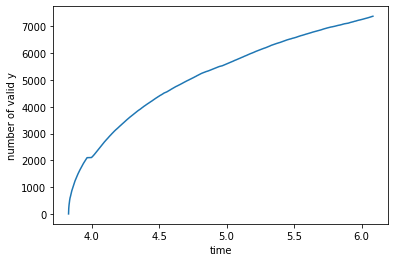

[3.830003261566162,
 3.8300070762634277,
 3.830010175704956,
 3.830012083053589,
 3.830014944076538,
 3.83001708984375,
 3.8300201892852783,
 3.830024242401123,
 3.8300259113311768,
 3.8300280570983887,
 3.8300461769104004,
 3.830048084259033,
 3.8300511837005615,
 3.83005428314209,
 3.83005690574646,
 3.830059051513672,
 3.8300621509552,
 3.8300652503967285,
 3.8300681114196777,
 3.830070972442627,
 3.830073118209839,
 3.830077886581421,
 3.830080986022949,
 3.8300840854644775,
 3.830087184906006,
 3.8300931453704834,
 3.8300981521606445,
 3.8301010131835938,
 3.8301050662994385,
 3.830108165740967,
 3.8301119804382324,
 3.8301150798797607,
 3.8301210403442383,
 3.830125093460083,
 3.8301281929016113,
 3.8301329612731934,
 3.830137014389038,
 3.830141305923462,
 3.8301451206207275,
 3.8301491737365723,
 3.830152988433838,
 3.830158233642578,
 3.8301639556884766,
 3.830169200897217,
 3.8301732540130615,
 3.830177068710327,
 3.8301820755004883,
 3.8301870822906494,
 3.8301920890808105,


In [25]:
path = 'tr1.png'
num_y_transition_nodup(df, num_reads, path)

In [26]:
rr = SA_res_valid_dic(df, res, valid_y_info_dic, num_reads)

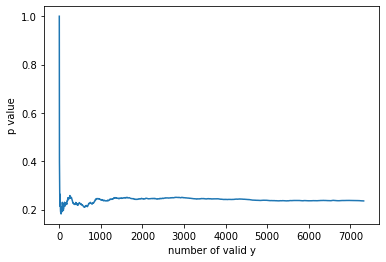

([(0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0),
  (1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1),
  (0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1),
  (1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1),
  (1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1),
  (0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1),
  (1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1),
  (0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1),
  (0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0),
  (1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1),
  (1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1),
  (1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1),
  (0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1),
  (1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1),
  (0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1),
  (0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0

In [27]:
path = 'tr2.png'
rr.p_value_transition(path)

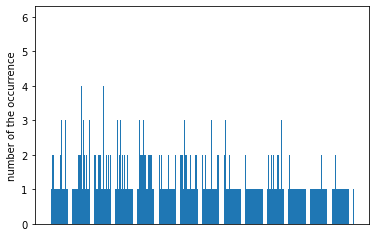

[1,
 2,
 1,
 3,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 3,
 3,
 1,
 1,
 3,
 3,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 3,
 2,
 1,
 1,
 3,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 3,
 3,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 3,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 3,
 4,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 3,
 1,
 3,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 4,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 3,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 4,
 2,
 3,
 1,
 2,
 2,


In [28]:
path = 'tr3.png'
rr.occurrence_hist(path)

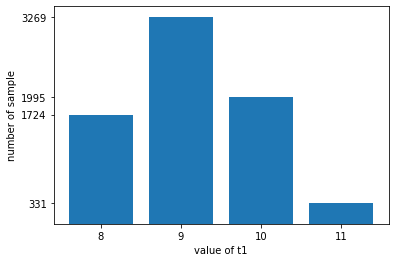

{8: 1724, 9: 3269, 11: 331, 10: 1995}

In [30]:
path = 'tr4.png'
rr.y_num_hist(path)

In [31]:
rr.calc_p_value()

0.23555130482306327